In [26]:
#reading relevant packages
import pandas as pd
import folium
import geopandas as gpd
import os
import fiona
from shapely.geometry import shape
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import gaussian_kde
import requests
import tempfile
import pandas as pd
import io
import json
import plotly.express as px

### (portfolio) Reading basemap SP

In [ ]:
### reading shapefile from url 
url = "https://github.com/yantoniassi1/yantoniassi1.github.io/raw/main/ProjectData/SIRGAS_SHP_distrito.zip"

# Fetch the zip file
response = requests.get(url)
if response.status_code == 200:
    with tempfile.NamedTemporaryFile(suffix=".zip") as tmp_zip:
        tmp_zip.write(response.content)
        tmp_zip.seek(0)  # Go back to the beginning of the file
        
        # Read the shapefile from the temporary zip file
        gdf_districts = gpd.read_file(f"zip://{tmp_zip.name}")
        
        # Display the first rows of the GeoDataFrame
        print(gdf.head())
else:
    print("Failed to download the zip file. HTTP status code:", response.status_code)


In [19]:
#set crs
gdf_districts.crs = "EPSG:31983"
gdf_districts = gdf_districts.to_crs("EPSG:4326")

print(gdf_districts.crs)

EPSG:4326


In [21]:
geojson_path = "SIRGAS_SHP_distritcs.json"
gdf_districts.to_file(geojson_path, driver="GeoJSON")
print(f"GeoJSON saved as {geojson_path}")

GeoJSON saved as SIRGAS_SHP_distritcs.json


### (portfolio) Reading Hospitals points

In [25]:
# reading shapefile from url 
url = "https://github.com/yantoniassi1/yantoniassi1.github.io/raw/main/ProjectData/loc_geosampa_cleaned.zip"

# Fetch the zip file
response = requests.get(url)
if response.status_code == 200:
    with tempfile.NamedTemporaryFile(suffix=".zip") as tmp_zip:
        tmp_zip.write(response.content)
        tmp_zip.seek(0)  # Go back to the beginning of the file
        
        # Read the shapefile from the temporary zip file
        gdf_hosps = gpd.read_file(f"zip://{tmp_zip.name}")
        
        # Display the first rows of the GeoDataFrame
        print(gdf.head())
else:
    print("Failed to download the zip file. HTTP status code:", response.status_code)

       ds_nome ds_codigo ds_cd_sub        ds_subpref ds_sigla    ds_areamt  \
0     MANDAQUI        51        05  SANTANA-TUCURUVI      MAN  13249456.11   
1        MOEMA        32        12      VILA MARIANA      MOE   9079516.47   
2  ARTUR ALVIM         5        21             PENHA      AAL   6505750.23   
3     IGUATEMI        33        30        SAO MATEUS      IGU  19434636.54   
4   ITAIM BIBI        35        11         PINHEIROS      IBI  10026327.68   

   ds_areakm                                           geometry  
0     13.249  POLYGON ((333079.583 7408102.398, 333077.161 7...  
1      9.080  POLYGON ((331290.13 7392111.284, 331324.217 73...  
2      6.506  POLYGON ((349420.638 7397694.618, 349423.468 7...  
3     19.435  POLYGON ((350874.784 7389641.837, 350875.63 73...  
4     10.026  POLYGON ((327871.085 7386152.364, 327865.295 7...  


In [44]:
# Check the CRS of both GeoDataFrames
print("Districts CRS:", gdf_districts.crs)
print("Hospitals CRS:", gdf_hosps.crs)

if gdf_districts.crs != gdf_hosps.crs:
    gdf_hosps = gdf_hosps.to_crs(gdf_districts.crs)

Districts CRS: EPSG:4326
Hospitals CRS: EPSG:4326


In [42]:
#save to geojson
geojson_path = "loc_healthfacilities.json"
gdf_hosps.to_file(geojson_path, driver="GeoJSON")
print(f"GeoJSON saved as {geojson_path}")

GeoJSON saved as loc_healthfacilities.json


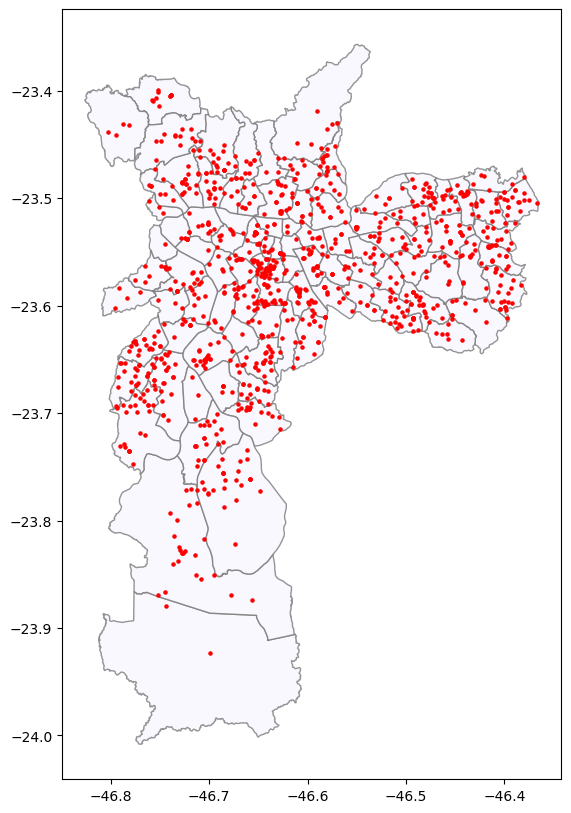

In [43]:
# Plot the basemap
ax = gdf_districts.plot(color='#F8F7FF', edgecolor='#7C7A7A', alpha=0.8, figsize=(10, 10))

# Overlay the points
gdf_hosps.plot(ax=ax, color='red', markersize=5)

# Show the plot
plt.show()

In [46]:
#value counts DEPADM	in gdf_hosps
gdf_hosps["DEPADM"].value_counts()

DEPADM
Municipal    882
Privado      165
Estadual      41
Federal        2
Name: count, dtype: int64

## Viz 2: dot plot or map showing healthcare expenditure 


#### Reading shapepefile of brazil

In [59]:
# Load the shapefile
bra_states = gpd.read_file('PortfolioData/BR_UF_2023/BR_UF_2023.shp')

# Display the first few rows
bra_states.head()

#turn CD_UF into numeric
bra_states['CD_UF'] = pd.to_numeric(bra_states['CD_UF'])

Text(0.5, 1.0, 'Brazil States')

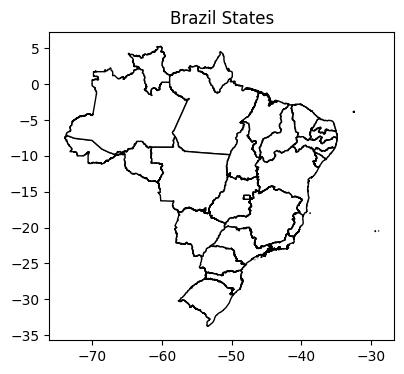

In [17]:
#plot the map
fig, ax = plt.subplots(figsize=(6, 4))
bra_states.plot(ax=ax, edgecolor='black', color='white')
plt.title('Brazil States')

#### Reading dataset IEPS with health expense data

In [60]:
#read expenses_timeseries_UF.csv
hexp_UF = pd.read_csv('ProjectData/expenses_timeseries_UF.csv')

#rename id_estado to CD_UF
hexp_UF = hexp_UF.rename(columns={"id_estado": "CD_UF"})

# Drop rows with NA in desp_tot_saude_pc_mun or desp_recp_saude_pc_mun
hexp_UF = hexp_UF.dropna(subset=['desp_tot_saude_pc_mun', 'desp_recp_saude_pc_mun'])

# Columns to process
columns_to_process = ['desp_tot_saude_pc_mun', 'desp_recp_saude_pc_mun']

# Replace ',' with '.', convert to numeric, and round to no decimals
hexp_UF[columns_to_process] = hexp_UF[columns_to_process].apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce').round(0))

#turn ano into date and keep only year
hexp_UF['ano'] = pd.to_datetime(hexp_UF['ano'], format='%Y')
hexp_UF['ano'] = hexp_UF['ano'].dt.year

#### Merging and plotting

In [61]:
#merge hexp_UF with bra_states
hexp_UF_geo = pd.merge(hexp_UF, bra_states, on='CD_UF')

#turn into geoDataFrame
hexp_UF_geo = gpd.GeoDataFrame(hexp_UF_geo, geometry='geometry')

#save to geojson
#hexp_UF_geo.to_file('hexp_UF_geo.geojson', driver='GeoJSON')

In [64]:
#drop rows with NA
hexp_UF_geo = hexp_UF_geo.dropna()

In [65]:
#drop rows with NA
hexp_UF_geo = hexp_UF_geo.dropna()

# Deduplicate geometries by state
hexp_UF_unique = hexp_UF_geo.drop_duplicates(subset='CD_UF').copy()

# Create a separate DataFrame for yearly data
yearly_hexp_UF = hexp_UF_geo[['CD_UF', 'ano', 'desp_tot_saude_pc_mun', 'desp_recp_saude_pc_mun']]

#rename ano to year
yearly_hexp_UF = yearly_hexp_UF.rename(columns={"ano": "year"})

In [66]:
# Save simplified geometry GeoJSON
hexp_UF_unique.to_file('hexp_UF_unique.geojson', driver='GeoJSON')

# Save yearly data as CSV for reference
yearly_hexp_UF.to_csv('yearly_hexp_UF.csv', index=False)

### Plotting

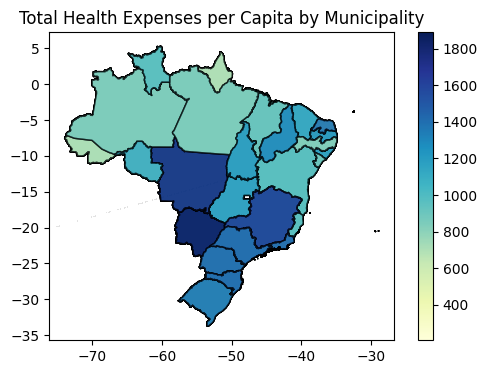

In [30]:
hexp_UF_geo = gpd.GeoDataFrame(hexp_UF_geo, geometry='geometry')

# Plot the map
fig, ax = plt.subplots(figsize=(6, 4))
hexp_UF_geo.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.6, column='desp_tot_saude_pc_mun', legend=True, cmap='YlGnBu')

# Set the title
plt.title('Total Health Expenses per Capita by Municipality')

# Show the plot
plt.show()

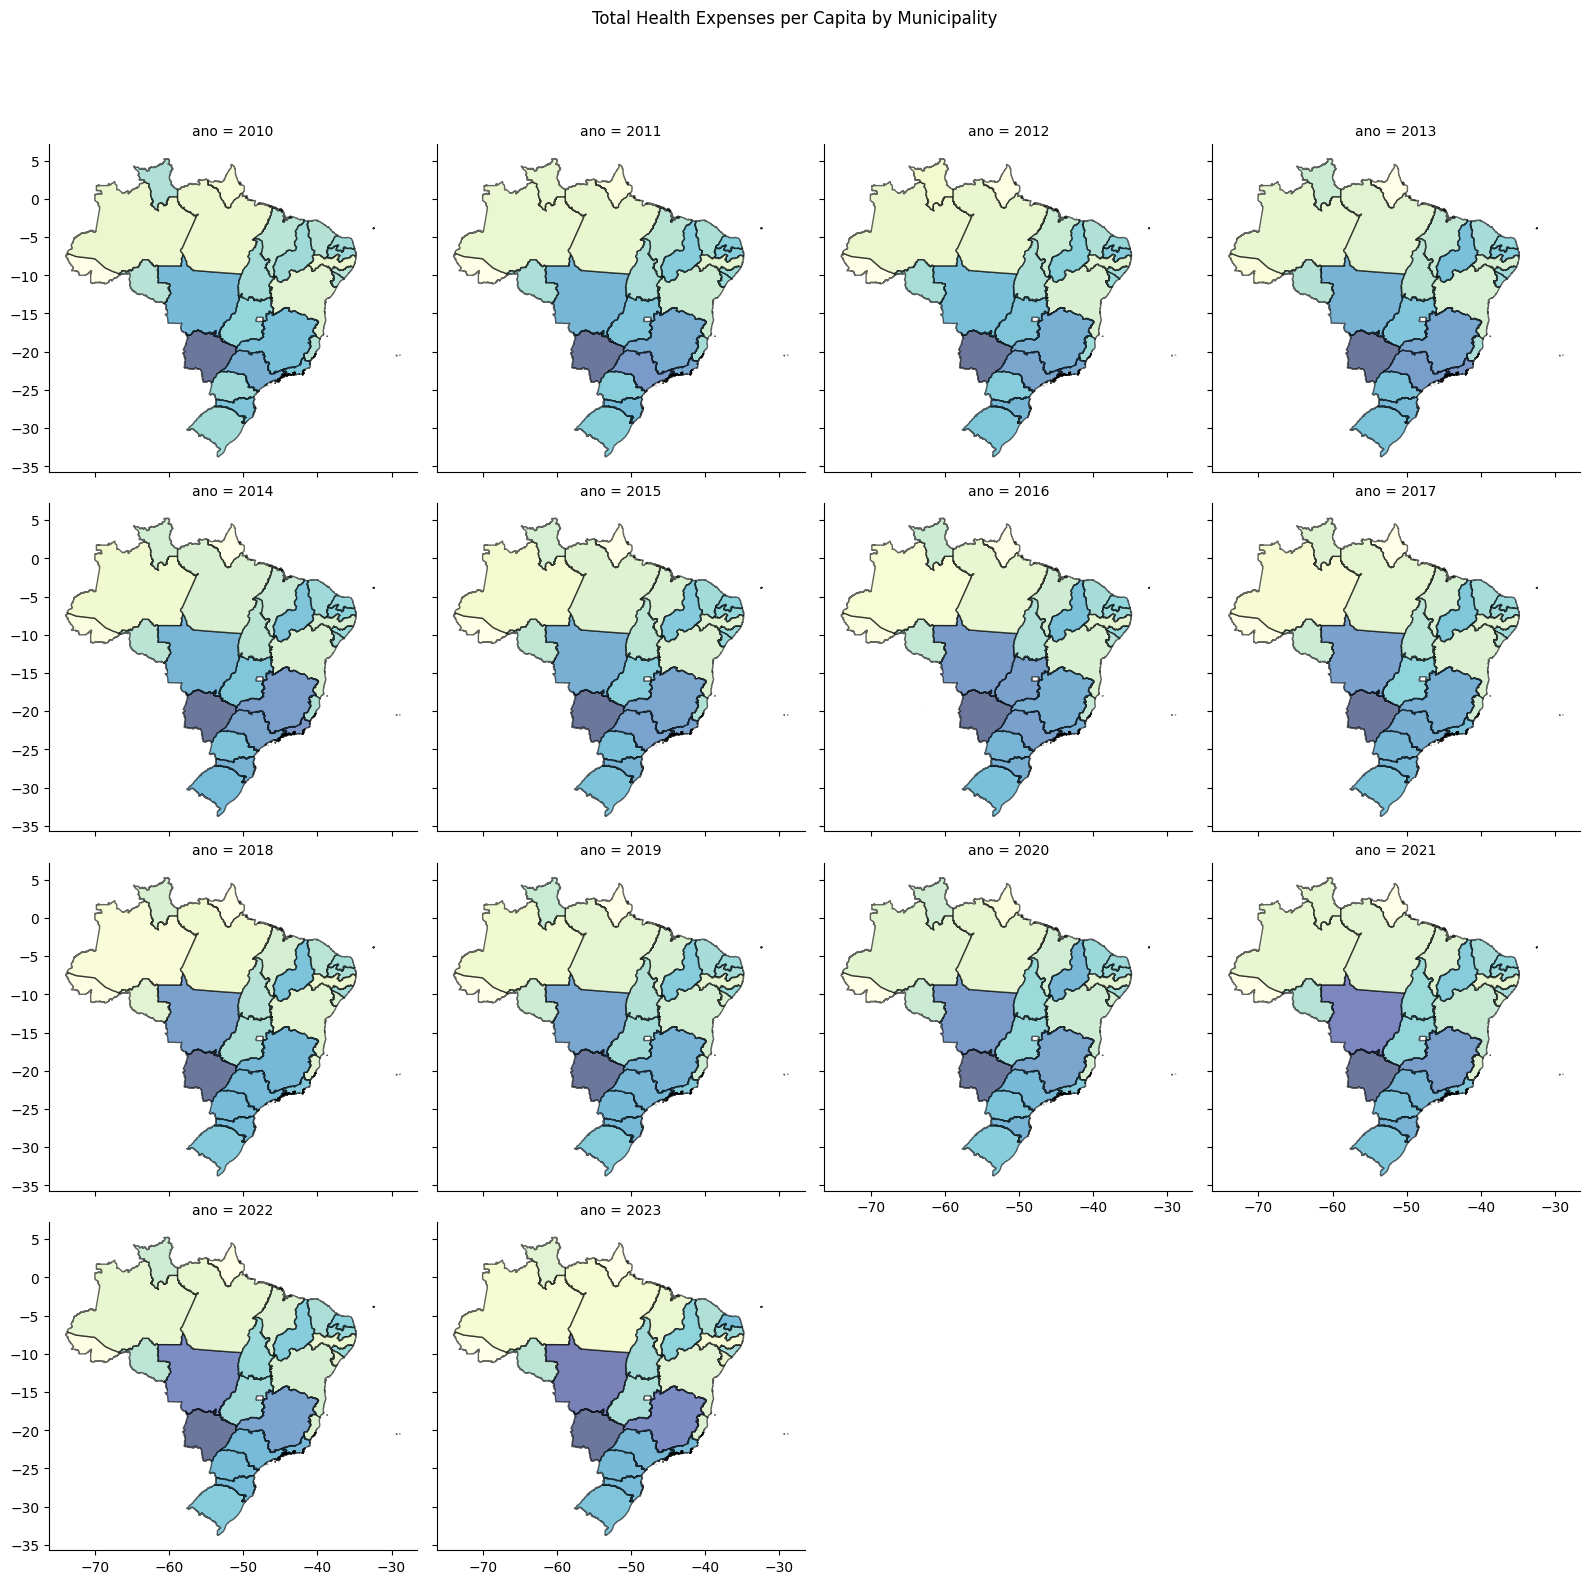

In [47]:
# Create a FacetGrid with seaborn
g = sns.FacetGrid(hexp_UF_geo, col="ano", col_wrap=4, height=4)

# Define a plotting function
def plot_map(data, **kwargs):
    ax = plt.gca()
    data.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.6, column='desp_tot_saude_pc_mun', legend=False, cmap='YlGnBu')

# Map the plotting function to the FacetGrid
g.map_dataframe(plot_map)

# Add a title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Health Expenses per Capita by Municipality')

# Show the plot
plt.show()

In [ ]:
# Load CSV
csv_data = pd.read_csv('ProjectData/yearly_hexp_UF.csv')
print(csv_data.head())

# Load GeoJSON
geo_data = gpd.read_file('ProjectData/hexp_UF_unique.geojson')
print(geo_data[['CD_UF']].head())

   CD_UF  year  desp_tot_saude_pc_mun  desp_recp_saude_pc_mun
0     12  2010                  205.0                   114.0
1     27  2010                  329.0                   125.0
2     13  2010                  264.0                   164.0
3     16  2010                  234.0                   111.0
4     29  2010                  286.0                   121.0
   CD_UF
0     12
1     27
2     13
3     16
4     29
set()
{53}


In [57]:
# Check unique state IDs
print(set(csv_data['CD_UF']).difference(set(geo_data['CD_UF'])))

set()


In [58]:
print(set(geo_data['CD_UF']).difference(set(csv_data['CD_UF'])))

{53}


## Viz 3: Treemap Expenses per Subarea

In [38]:
#read from github https://github.com/yantoniassi1/yantoniassi1.github.io/blob/main/ProjectData/exp_subarea_UF_2023.csv
url = "https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/ProjectData/exp_subarea_UF_2023.csv"

# Fetch the CSV content
response = requests.get(url)
response.raise_for_status()  # Ensure we notice bad responses

# Read the CSV content into a pandas DataFrame
exp_subarea_UF = pd.read_csv(io.StringIO(response.text))

In [39]:
#split CD_UF into two columns
exp_subarea_UF[['CD_UF', 'NAME_UF']] = exp_subarea_UF['CD_UF'].str.split(' ', n=1, expand=True)

#inspecting type of columns
exp_subarea_UF.dtypes

#turn , into .
exp_subarea_UF = exp_subarea_UF.apply(lambda x: x.str.replace(',', '.'))

#turn all expect NAME_UF into numeric
exp_subarea_UF = exp_subarea_UF.apply(pd.to_numeric, errors='ignore')

/var/folders/91/0p_7xl4n1wzcnkf1483hnvfm0000gn/T/ipykernel_63050/694057519.py:11: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



### Plotting a treemap

In [40]:
# Filter the DataFrame to include only the 'Total' row in the 'CD_UF' column
total_row = exp_subarea_UF[exp_subarea_UF['CD_UF'] == 'Total']

# Melt the DataFrame to long format
melted_total_row = total_row.melt(id_vars=['CD_UF', 'NAME_UF'], var_name='Subarea', value_name='Value')

# Create a mapping dictionary for the larger groups
group_mapping = {
    '02': 'Diagnostic Procedures',
    '03': 'Clinical Procedures',
    '04': 'Surgical Procedures',
    '05': 'Organ, Tissue, and Cell Transplants'
}

# Add a new column for the larger group
melted_total_row['Group'] = melted_total_row['Subarea'].str[:2].map(group_mapping)

In [ ]:
#save dataset 
#melted_total_row.to_csv('exp_subarea_total_2023.csv', index=False)

#head
melted_total_row.head()

#delete rows with CD_UF and NAME_UF
melted_total_row = melted_total_row.drop(['CD_UF', 'NAME_UF'], axis=1)

In [51]:
melted_total_row.head()

,CD_UF,NAME_UF,Subarea,Value,Group
0,Total,None,0201 Collection of material,8.082273e+06,Diagnostic Procedures
1,Total,None,0209 Diagnosis by endoscopy,2.589501e+07,Diagnostic Procedures
2,Total,None,0211 Diagnostic methods in specialties,5.169559e+06,Diagnostic Procedures
3,Total,None,0301 Consultations / Appointments / Follow-ups,6.475043e+07,Clinical Procedures
4,Total,None,0303 Clinical treatments (other specialties),7.409911e+09,Clinical Procedures


In [52]:
state_data = {}
for state, group_data in melted_total_row.groupby('NAME_UF'):
    state_data[state] = group_data.to_dict(orient='records')

with open('statewise_treemap.json', 'w') as f:
    json.dump(state_data, f)

In [56]:
url = "https://raw.githubusercontent.com/yantoniassi1/yantoniassi1.github.io/main/ProjectData/exp_subarea_total_2023.csv"

# Fetch the CSV content
response = requests.get(url)

# Read the CSV content into a pandas DataFrame
melted_total_row = pd.read_csv(io.StringIO(response.text))

# Create a treemap
fig = px.treemap(
    melted_total_row,
    path=['Group', 'Subarea'],
    values='Value',
    color='Group',
    title='Treemap of Total Expenses per Subarea'
)

# Show the plot
fig.show()

In [58]:
fig.write_json('total_treemap.json')